# Panorama Mosaic

Aluno: Arthur Souto Lima  
Mat.: 2018055113

## Algoritmos

No primeiro momento, são apresentados os algoritmos que permitirão a criação dos mosaicos.

### Imports e Funções Auxiliares

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(cv2_img,title=""):
    """
    Show an OpenCV BGR image

    Parameters:
        cv2_img: an BGR image
        title: (optional) title to be plotted above
    
    Returns:
        None
    """
    if title:
        plt.title(title)
    plt.imshow(cv.cvtColor(cv2_img, cv.COLOR_BGR2RGB))
    plt.show()

In [3]:
def image_resize(image, width=None, height=None, inter=cv.INTER_AREA):
    """
    Resize an image keeping aspect ratio
    
    Parameters:
        image: image to be resized
        width: (optional) resized width
        height: (optional) resized height
        inter: interpolation method. Defaults to cv.INTER_AREA
    
    Source:
    https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
    """
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [4]:
def crop(mosaic):
    """
    Crops only the relevant area from raw mosaic result
    
    Parameters:
        mosaic: panorama mosaic with unused areas
    Returns:
        result: cropped image
    
    Source:
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    # Transform the panorama image to grayscale and threshold it 
    gray = cv.cvtColor(mosaic, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)[1]

    # Finds contours from the binary image
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if (len(cnts) == 2): 
        cnts = cnts[0]

    # Get the maximum contour area
    c = max(cnts, key=cv.contourArea)

    # Get a bbox from the contour area
    (x, y, w, h) = cv.boundingRect(c)

    # Crop the image to the bbox coordinates
    result = mosaic[y:y + h, x:x + w]

    return result

In [5]:
def show3(img1, img2, img3, maxHeight):
    """
    Plots three BGR images side-to-side
    Resizes them to plot if they are higher than specified maximum height
    
    Parameters:
        img1: image to be plotted in the left
        img2: image to be plotted in the center
        img3: image to be plotted in the right
        maxHeight: maximum allowed height for plotting
    Returns:
        None
        
    Adapted from:
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)
        
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, 
                                   constrained_layout=False, figsize=(15,15))
    ax1.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    ax1.set_xlabel("Image 1")
    ax2.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
    ax2.set_xlabel("Image 2")
    ax3.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
    ax3.set_xlabel("Image 3")
    plt.show()
    
def show2(img1, img2, maxHeight):
    """
    Plots two BGR images side-to-side. 
    Resizes them to plot if they are higher than specified maximum height
    
    Parameters:
        img1: image to be plotted in the left
        img2: image to be plotted in the right
        maxHeight: maximum allowed height for plotting
    Returns:
        None
        
    Adapted from:
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)
        
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, 
                                   constrained_layout=False, figsize=(10,10))
    ax1.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    ax1.set_xlabel("Image 1")
    ax2.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
    ax2.set_xlabel("Image 2")
    plt.show()

### Detecção e Descrição de Keypoints

Para poder fazer os mosaicos, precisamos detectar e descrever os keypoints das imagens. A função abaixo computa essas informações necessárias usando algum método especificado. Há um número máximo de keypoints que podem ser retornados por questões de desempenho, visto que posteriormente faremos o casamento usando força-bruta, logo uma quantidade muito grande inviabiliza os procedimentos. É importante ter cuidado com esse número, pois se ele for muito baixo, pode ser que um mínimo suficiente de casamentos não seja possível e inviabilize a formação do mosaico.

In [6]:
def detectAndDescribe(img, method, n_keypoints=5000):
    """
    Detect and describe keypoints in passed image using said method.
    
    Parameters:
        img: image where we'll detect the keypoints
        method: method for describing the keypoints
        n_keypoints: maximum number of found keypoints. Defaults to 5000
    Returns:
        kpts: list of keypoints
        descriptors: list of descriptors to these keypoints
    
    Adapted from:
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    OpenCV, BRIEF
    """
    
    kpts, descriptors = None, None
    if method == 'sift':
        # Uses SIFT detector and extractor
        sift = cv.xfeatures2d.SIFT_create(n_keypoints)
        kpts, descriptors = sift.detectAndCompute(img, None)
        
    elif method == 'brief':
        # Uses SIFT detector and BRIEF extractor
        sift = cv.xfeatures2d.SIFT_create(n_keypoints)
        brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
        
        # Find keypoints via SIFT detector
        kp = sift.detect(img,None)
        
        # Compute the descriptors with BRIEF
        kpts, descriptors = brief.compute(img, kp)
    
    return kpts, descriptors

In [7]:
def drawKeypoints(img, kpts, features):
    """
    Plots an image with its keypoints
    
    Parameters: 
        img: image to serve as a background to the plot
        kpts: image keypoints
        features: keypoints' description 
    Returns:
        None
    """
    plt.imshow(cv.drawKeypoints(img,kpts,None,color=(0,255,0)))

### Casamento de Keypoints

Como já comentado, para que seja possível mesclar as imagens é necessário que seja feita um casamento entre os keypoints encontrados. Aqui usaremos apenas o método força-bruta. Também como já citado, por conta dele deve-se limitar a quantidade de keypoints reportados numa única imagem.

In [8]:
def matchKeyPointsBF(featuresA, featuresB, prints=False):
    """
    Matches keypoints using Brute-Force matcher
    
    Parameters:
        featuresA: descriptors from first image
        featuresB: descriptors from second image
        prints: prints some progress information if true
    Returns:
        rawMatches: unordered list of matches
        
    Adapted from: 
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    # Creates Brute-Force matcher using Euclidean Distance to find matches
    # crossCheck allows us to have a more robust matching
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    
    # Print how many matches, if needed
    print(f"FeaturesA: {len(featuresA)}")
    print(f"FeaturesB: {len(featuresB)}")
    print("Raw matches (Brute force):", len(rawMatches))

    return rawMatches

In [9]:
def drawMatches(img1, kps1, img2, kps2, matches, qtd=100):
    """
    Plots some resulting matches between keypoints
    
    Parameters:
        img1: first image, to serve as background
        kps1: first image's keypoints
        img2: second image, to serve as background
        kps2: second image's keypoints
        matches: list of matches between these keypoints
        qtd: how many matches will be plotted. Defaults to 100. 
             Must be less than number of matches
    Returns:
        None
    
    Adapted from: 
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    if (qtd > len(matches)):
        raise "Too few matches to plot"
    
    fig = plt.figure(figsize=(20,8))
    img = cv.drawMatches(img1, kps1, img2, kps2,
                         matches[:qtd], None,
                         flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    show(img)

### Homografia

Com os keypoints já descritos e casados, utilizamos a função do OpenCV _findHomography_ para encontrar a matriz de transformação. Com ela, será possível implementar a _warpPerspective_ para criar os mosaicos

In [10]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    """
    Creates homography matrix using RANSAC to more robust estimation
    
    Parameters:
        kpsA: first image's keypoints
        kpsB: second image's keypoints
        featuresA: first image's keypoints
        featuresB: second image's keypoints
        matches: list of keypoint matches
        reprojThresh: reprojection threshold for homography OpenCV function
    
    Returns:
        H: homography matrix
        status: if the algorithm was capable of finding a valid homography
        
    Adapted from:
    Thalles Silva, Image Panorama Stitching with OpenCV (2019)
    """
    # Convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    # Construct the two sets of points
    ptsA = []
    ptsB = []
    for m in matches:
        ptsA.append(np.float32(kpsA[m.queryIdx]))
        ptsB.append(np.float32(kpsB[m.trainIdx]))
    ptsA, ptsB = np.array(ptsA), np.array(ptsB)
    
    # Estimate the homography between the sets of points
    H, status = cv.findHomography(ptsA, ptsB, cv.RANSAC, reprojThresh)

    return H, status

### _warpPerspective_

Inicialmente, vamos trabalhar com uma _warpPerspective_ "simples", que ou faz a média ou dá a preferência para uma das imagens. 

In [11]:
def blendAverage(pix1, pix2):
    """
    Blends pixel1 and pixel2 by averaging them
    
    Parameters:
        pix1: first pixel
        pix2: second pixel
    Returns:
        avg: averaged pixel
    """
    if (np.sum(pix1) == 0):
        # Zero pixel, use only other one
        return pix2
    elif (np.sum(pix2) == 0):
        # Zero pixel, use only other one
        return pix1
    else:
        return 0.5*pix1 + 0.5*pix2

In [12]:
def blendPreferBase(pix1, pix2):
    """
    Blends pixel1 and pixel2 by prefering the first one
    if it is non-zero
    
    Parameters:
        pix1: first pixel
        pix2: second pixel
    Returns:
        avg: averaged pixel
    """
    if (np.sum(pix1) == 0):
        # Zero pixel, use only other one
        return pix2
    else:
        # Prefer the first one
        return pix1

In [13]:
def blendPreferOther(pix1, pix2):
    """
    Blends pixel1 and pixel2 by prefering the second one
    if it is non-zero
    
    Parameters:
        pix1: first pixel
        pix2: second pixel
    Returns:
        avg: averaged pixel
    """
    if (np.sum(pix2) == 0):
        # Zero pixel, use only other one
        return pix1
    else:
        # Prefer the first one
        return pix2

In [14]:
def warpPerspectiveSimple(src, dest, H, method, prints=False):
    """
    Performs warpPerspective from source image to destination.
    Blends intersecting pixels using a specific method.
    
    Parameters:
        src: source image
        dest: destination image
        H: homography matrix to transform src into dest
        method: blending method to be used in the intersection area
        prints: prints some progress information if true 
    Returns:
        dest: blended images
    """
    
    if (dest is None):
        # destination is a blank image
        dest = np.zeros((src.shape[0]*2, src.shape[1]*2, src.shape[2]), 
                         dtype=np.uint8)
    
    # In order to avoid interpolation problems, 
    # we'll warp from destination to find correspondent
    # pixels in source image
    
    _, H1 = cv.invert(H)    # We'll need H^-1 to do this
    
    for i in range(dest.shape[0]):
        for j in range(dest.shape[1]):
            res = np.dot(H1, [j,i,1])  # j is for columns <-> equivalent to x
                                       # i is for rows    <-> equivalent to y
            i2,j2,_ = (res/res[2]).astype(int)  # De-homogenizing
            
            if i2 >= 0 and i2 < src.shape[1]:
                if j2 >= 0 and j2 < src.shape[0]:
                    pixel_src = src[j2,i2]
                    pixel_dest = dest[i,j]
                    
                    # Blending function:
                    if (method == "average"):
                        dest[i,j] = blendAverage(pixel_src, pixel_dest)
                    elif (method == "other"):
                        dest[i,j] = blendPreferBase(pixel_src, pixel_dest)
                    elif (method == "base"):
                        dest[i,j] = blendPreferOther(pixel_src, pixel_dest)
                    else:
                        raise "Invalid Blending Method"
    return dest

### Feathering

Para fazer o efeito de feathering, são necessárias algumas funções auxiliares. Principalmente para criar máscaras que servirão de pesos para as imagens. A _warpPerspective_ usada nesses casos é a _warpPerspectiveSimple_ já descrita acima. Faremos a mistura (blending) utilizando as máscaras, após a transformação, ao invés de fazer durante o warping como foram os casos dos outros tipos de blending. 

Escolhemos essa estratégia pois, no meio do processo, após a transformação da imagem via homografia, perde-se a facilidade do cálculo da distância até a borda (não é mais apenas uma questão de somas e subtrações). Assim, consideramos mais fácil calcular isso previamente, ou seja, com as imagens ainda no início do processo, e guardar essa informação em máscaras, fazendo a transformação nelas também para, posteriormente, realizar o blending.

In [15]:
def distMask(img):
    """
    Computes pixel distance to borders and 
    creates a mask with this information
    
    Parameters:
        img: image to be processed
    Return:
        result: mask
    """
    result = np.zeros(img.shape)
    
    maxRow = img.shape[0]
    maxCol = img.shape[1]
    for i in range(maxRow):
        for j in range(maxCol):
            # Vertical Distance
            distTop = i
            distBot = (maxRow-1) - i
            distRow = min(distTop, distBot)
            
            # Horizontal Distance
            distLft = j
            distRgt = (maxCol-1) - j
            distCol = min(distLft, distRgt)
            
            # Total Distance
            dist = min(distRow, distCol)
            result[i][j] = dist + 1   # So we don't have zeros
    cv.normalize(result, result, 1, 255, cv.NORM_MINMAX)
    result = result / 255
    # result = np.uint8(result)
    return result

In [16]:
def distMasks(base_img_unpadded, other_img_unflipped, H):
    """
    Creates distance-to-border-based masks for both images, given also the homography matrix
    
    Parameters:
        base_img_unpadded: base image (not to be transformed) without padding
        other_img_unflipped: image to be transformed, not yet transformed
        H: homograpy matrix to transform other_image to blend into base_image
    Returns:
        m_base_padded: mask for base image, already padded
        m_other_flipped: mask for other image, already transformed
    """
    ## Can only be applied to two image mosaics
    # Mask for base image, without padding: floats from 0 to 1
    m_base_normal = distMask(base_img_unpadded)    
    
    # Mask for to-be-transformed image, in yet to be transformed state
    # floats from 0 to 1
    m_other_normal = distMask(other_img_unflipped)   

    # Mask padding
    width = other_img_unflipped.shape[1]
    m_base_padded = cv.copyMakeBorder(m_base_normal, 0, 0, width, width, cv.BORDER_CONSTANT)
    
    # Mask transformation via homography
    # Converts to uint8 to be able to transform
    m_other_normal_uint8 = np.uint8(m_other_normal*255)
    blank_canvas = np.zeros((m_base_padded.shape[0], m_base_padded.shape[1], base_img_unpadded.shape[2]), dtype=np.uint8)
    result = warpPerspectiveSimple(m_other_normal_uint8, blank_canvas, H, "average", False)
    m_other_flipped = result/255
    return m_base_padded, m_other_flipped

## Criador de Panorama Completo

### Blending Simples

Para consolidar tudo o que foi implementado, vamos criar uma função única que recebe as imagens juntamente com mais alguns parâmetros e cria o mosaico panorama. A primeira versão é um que consolida duas imagens apenas.

In [17]:
def panoramaMosaic2(img1, img2, maxHeight=500, 
                    kpts_method='sift', n_kpts=5000, 
                    blending_method='average',
                    prints=False, two_image_mosaic=False):
    """
    Blends two images into a panorama mosaic
    
    Parameters:
        img1: first image
        img2: second image
        maxHeight: maximun image height, they'll be resized if they are bigger
        kpts_method: keypoint description method. 
                     Either 'sift' or 'brief'. Defaults to 'sift'
        n_kpts: maximum quantity of keypoints per image
        blending_method: method for blending images. Defaults to 'average'
        prints: prints some progress information if true. Defaults to false.
        two_image_mosaic: must be flagged true if we have a 2-image only mosaic.
                          Defaults to false.
        
    Returns:
        result: panorama image blending both images
    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)
        
    if (two_image_mosaic):
        # If we have a two-image only mosaic, we need to add some side 
        # padding to the base image
        img2 = cv.copyMakeBorder(img2, 0, 0, img1.shape[1], img1.shape[1], cv.BORDER_CONSTANT)
    
    ## Blends img1 into img2
    # Make a grayscale copy of both images
    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    print("Grayscale")
    
    # Detect and Describe Keypoints
    keys1, feats1 = detectAndDescribe(img1_gray, kpts_method, n_kpts)
    keys2, feats2 = detectAndDescribe(img2_gray, kpts_method, n_kpts)
    print("Keypoints")
    
    # Keypoint Matching
    matches = matchKeyPointsBF(feats1, feats2, prints)
    print("Matches")
    if (prints): drawMatches(img1, keys1, img2, keys2, matches)
    print("DrawMatches")
    
    # Estimate Homography
    H, status = getHomography(keys1, keys2, 
                              feats1, feats2, 
                              matches, reprojThresh=4)
    print("Homography")
    
    # Creates mosaic by applying homography
    result = warpPerspectiveSimple(img1, img2, H, blending_method, prints)
    print("Mosaic")
    
    if (two_image_mosaic):
        # Cropping non used parts
        result = crop(result)
    return result

A segunda versão combina três imagens.

In [18]:
def panoramaMosaic3(img1, img2, img3, maxHeight=500, 
                    method='sift', n_kpts=5000, 
                    blending_method='average',
                    prints=False,):
    """
    Blends three images into a panorama mosaic
    
    Parameters:
        img1: left image
        img2: center image
        img3: right image
        maxHeight: maximun image height, they'll be resized if they are bigger
        method: keypoint description method. Either 'sift' or 'brief'. Defaults to 'sift'
        n_kpts: maximum quantity of keypoints per image
        blending_method: method for blending images. Defaults to 'average'
        prints: prints some progress information if true. Defaults to false.
    
    Returns
        result: panorama image blending given images

    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)
        img3 = image_resize(img3, height=maxHeight)
    
    # As the central image, we'll add some padding to the side of img2 
    #so we can place and blend the other two images into it
    img2 = cv.copyMakeBorder(img2, 0, 0, img1.shape[1], img3.shape[1], cv.BORDER_CONSTANT)
    

    ## Blends img1 into img2
    img2 = panoramaMosaic2(img1, img2, maxHeight=maxHeight,
                           kpts_method=method, n_kpts=n_kpts, 
                           prints=prints, two_image_mosaic=False)
    print("img1->2 done")
    ## Blends img3 into img2 (which is now a blend of img1 and original img2)
    result = panoramaMosaic2(img3, img2, maxHeight=maxHeight,
                             kpts_method=method, n_kpts=n_kpts, 
                             prints=prints, two_image_mosaic=False)
    print("img3->2 done")
    # Cropping non used parts
    result = crop(result)
    print("Mosaic")
    return result

### Blending Feathering

Apesar de boa parte do procedimento ser parecido, temos que adotar uma estratégia diferente com o blending de feathering. Para o fazermos, vamos usar algumas máscaras e vamos juntar as imagens de uma só vez, como já discutido na seção de Feathering.

#### 2 imagens

In [19]:
def sumWithMasks2(base_img_padded, mask_base_padded, other_img_flipped, mask_other_flipped):
    """
    Blends two images by weighting them by their correspondent masks
    
    Parameters:
        base_img_padded: base image, already padded
        mask_base_padded: mask for base image, already padded
        other_img_flipped: to-be-transformed image, already transformed
        mask_other_flipped: mask for to-be-transformed image
    Returns:
        res_int: result blended image
    """
    
    num = base_img_padded*mask_base_padded + other_img_flipped*mask_other_flipped
    den = mask_base_padded + mask_other_flipped
    res_f = np.divide(num, den, where=(den!=0))
    res_int = np.uint8(res_f)
    return res_int

In [20]:
def panoramaMosaic2Special(img1, img2, maxHeight=500, kpts_method='sift',n_kpts=5000, prints=False):
    """
    Blends two images into a panorama mosaic
    
    Parameters:
        img1: to-be-transformed image
        img2: base image
        maxHeight: maximum height. If images are bigger, they will be resized
        kpts_method: keypoint description method. 
                     Either 'sift' or 'brief'. Defaults to 'sift'
        n_kpts: maximum quantity of keypoints per image
        prints: prints some progress information if true. Defaults to false.
        
    Returns:
        res: panorama image blending the images
    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)

    # Padding base-image so we can form the mosaic 
    img2_pad = cv.copyMakeBorder(img2, 0, 0, img1.shape[1], img1.shape[1], cv.BORDER_CONSTANT)

    # Make a grayscale copy of images
    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2_pad, cv.COLOR_BGR2GRAY)
    print("Grayscale")

    # Detect and Describe Keypoints
    keys1, feats1 = detectAndDescribe(img1_gray, kpts_method, n_kpts)
    keys2, feats2 = detectAndDescribe(img2_gray, kpts_method, n_kpts)
    print("Keypoints")

    # Keypoint Matching
    matches12 = matchKeyPointsBF(feats1, feats2, prints)
    print("Matches")
    if (prints): drawMatches(img1, keys1, img2, keys2, matches)
    print("DrawMatches")

    # Estimate Homography
    H12, status12 = getHomography(keys1, keys2, 
                                  feats1, feats2, 
                                  matches12, reprojThresh=4)
    print("Homography")

    # Appliying homography onto blank canvas
    blank_canvas = np.zeros((img2_pad.shape[0], img2_pad.shape[1], img2_pad.shape[2]), dtype=np.uint8)
    img1_flip = warpPerspectiveSimple(img1, blank_canvas, H12, "average", prints)
    print("Transform img1")
    
    # Masks to help blending
    m_img2_pad, m_img1_flp = distMasks(img2, img1, H12)
    print("Masks 12")
    
    # Feathering
    res = sumWithMasks2(img2_pad, m_img2_pad, img1_flip, m_img1_flp)
    # Cropping non used parts
    res = crop(res)
    print("Mosaic")
    if (prints):
        plt.figure(figsize=(20,10))
        show(res)
    return res

#### 3 imagens

Aqui ao invés de transformar a primeira para juntar com a segunda e a partir da junção das duas ligar a terceira, vamos já calcular duas homografias: da primeira para a segunda (central) e da terceira para a segunda. Após isso,  vamos juntar as três de uma vez.

In [21]:
def sumWithMasks3(center_img_padded, mask_center_padded, 
                  left_img_flipped, mask_left_flipped,
                  right_img_flipped, mask_right_flipped):
    """
    Blends three images by weighting them by their correspondent masks
    
    Parameters:
        center_img_padded: center image, base to the mosaic, 
                           won't be transformed, already padded.
        mask_center_padded: 
    Returns:
        res_int: result blended image
    """
    
    num = (center_img_padded*mask_center_padded + 
           left_img_flipped*mask_left_flipped +
           right_img_flipped*mask_right_flipped)
    den = mask_center_padded + mask_left_flipped + mask_right_flipped
    res_f = np.divide(num, den, where=(den!=0))
    res_int = np.uint8(res_f)
    return res_int

In [22]:
def panoramaMosaic3Special(img1, img2, img3, maxHeight=500, kpts_method='sift',n_kpts=5000, prints=False):
    """
    Blends three images into a panorama mosaic
    
    Parameters:
        img1: left image
        img2: center image
        img2: right image
        maxHeight: maximum height. If images are bigger, they will be resized
        kpts_method: keypoint description method. 
                     Either 'sift' or 'brief'. Defaults to 'sift'
        n_kpts: maximum quantity of keypoints per image
        prints: prints some progress information if true. Defaults to false.
        
    Returns:
        res: panorama image blending the images
    """
    # Resize images if they are too large
    if (img1.shape[0] > maxHeight):
        img1 = image_resize(img1, height=maxHeight)
        img2 = image_resize(img2, height=maxHeight)
        img3 = image_resize(img3, height=maxHeight)

    # Padding center-image so we can form the mosaic 
    img2_pad = cv.copyMakeBorder(img2, 0, 0, img1.shape[1], img3.shape[1], cv.BORDER_CONSTANT)

    # Make a grayscale copy of images
    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2_pad, cv.COLOR_BGR2GRAY)
    img3_gray = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)
    print("Grayscale")

    # Detect and Describe Keypoints
    keys1, feats1 = detectAndDescribe(img1_gray, kpts_method, n_kpts)
    keys2, feats2 = detectAndDescribe(img2_gray, kpts_method, n_kpts)
    keys3, feats3 = detectAndDescribe(img3_gray, kpts_method, n_kpts)
    print("Keypoints")

    # Keypoint Matching
    matches12 = matchKeyPointsBF(feats1, feats2, prints)
    matches32 = matchKeyPointsBF(feats3, feats2, prints)
    print("Matches")

    if (prints): drawMatches(img1, keys1, img2_pad, keys2, matches12)
    if (prints): drawMatches(img3, keys3, img2_pad, keys2, matches32)
    print("DrawMatches")

    # Estimate Homography
    H12, status12 = getHomography(keys1, keys2, 
                                  feats1, feats2, 
                                  matches12, reprojThresh=4)
    H32, status32 = getHomography(keys3, keys2, 
                                  feats3, feats2, 
                                  matches32, reprojThresh=4)
    print("Homography")

    # Appliying homography onto blank canvas
    blank_canvas = np.zeros((img2_pad.shape[0], img2_pad.shape[1], img2_pad.shape[2]), dtype=np.uint8)
    img1_flip = warpPerspectiveSimple(img1, blank_canvas, H12, "average", prints)
    print("Transform img1")
    blank_canvas = np.zeros((img2_pad.shape[0], img2_pad.shape[1], img2_pad.shape[2]), dtype=np.uint8)
    img3_flip = warpPerspectiveSimple(img3, blank_canvas, H32, "average", prints)
    print("Transform img3")
    
    # Masks to help blending
    m_img2_pad, m_img1_flp = distMasks(img2, img1, H12)
    print("Masks 12")
    m_img2_pad, m_img3_flp = distMasks(img3, img1, H32)
    print("Masks 32")
    
    # Feathering
    res = sumWithMasks3(img2_pad, m_img2_pad, img1_flip, m_img1_flp, img3_flip, m_img3_flp)
    
    # Cropping non used parts
    res = crop(res)
    print("Mosaic")
    if (prints):
        plt.figure(figsize=(20,10))
        show(res)
    return res

## Exemplos

### Exemplo 1 - tutorial

O primeiro conjunto de imagens advém do tutorial (Silva, 2019) que serviu de base para esse projeto. Vamos focar, nesse momento, nas diferentes formas de blending.

In [23]:
src1 = 'foto1A.jpg'
src2 = 'foto1B.jpg'
img1 = cv.imread(src1)
img2 = cv.imread(src2)

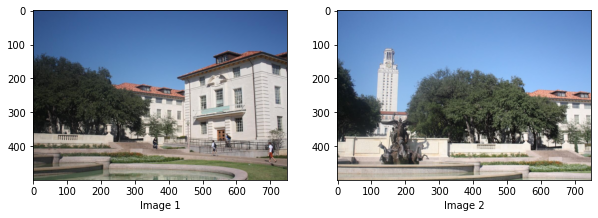

In [24]:
show2(img1, img2, 500)

In [25]:
avg = panoramaMosaic2(img1, img2, maxHeight=500,
                      kpts_method='sift', blending_method='average', 
                      prints=False, two_image_mosaic=True)

Grayscale
Keypoints
FeaturesA: 2385
FeaturesB: 3085
Raw matches (Brute force): 1079
Matches
DrawMatches
Homography
Mosaic


In [26]:
base = panoramaMosaic2(img1, img2, maxHeight=500,
                       kpts_method='sift', blending_method='base', 
                       prints=False, two_image_mosaic=True)

Grayscale
Keypoints
FeaturesA: 2385
FeaturesB: 3085
Raw matches (Brute force): 1079
Matches
DrawMatches
Homography
Mosaic


In [27]:
other = panoramaMosaic2(img1, img2, maxHeight=500,
                        kpts_method='sift', blending_method='other', 
                        prints=False, two_image_mosaic=True)

Grayscale
Keypoints
FeaturesA: 2385
FeaturesB: 3085
Raw matches (Brute force): 1079
Matches
DrawMatches
Homography
Mosaic


In [28]:
special = panoramaMosaic2Special(img1, img2, maxHeight=500,
                                 kpts_method='sift', prints=False)

Grayscale
Keypoints
FeaturesA: 2385
FeaturesB: 3085
Raw matches (Brute force): 1079
Matches
DrawMatches
Homography
Transform img1
Masks 12
Mosaic


In [29]:
brief = panoramaMosaic2Special(img1, img2, maxHeight=500,
                               kpts_method='brief', prints=False)

Grayscale
Keypoints
FeaturesA: 2194
FeaturesB: 3016
Raw matches (Brute force): 775
Matches
DrawMatches
Homography
Transform img1
Masks 12
Mosaic


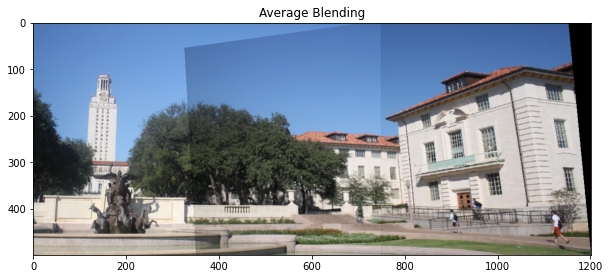

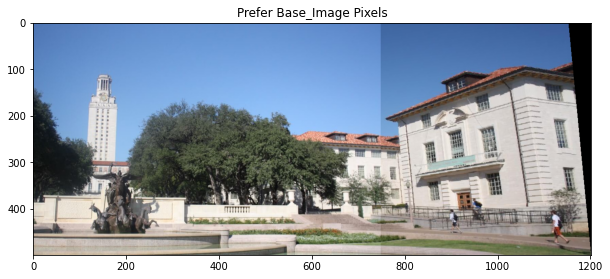

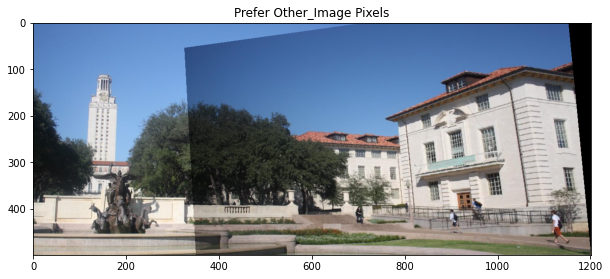

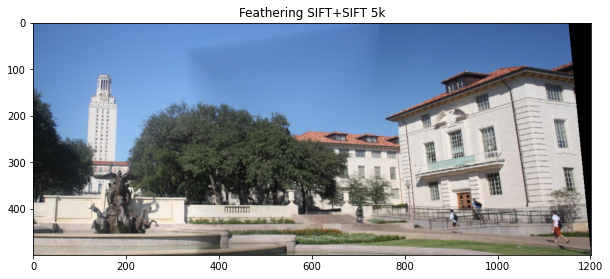

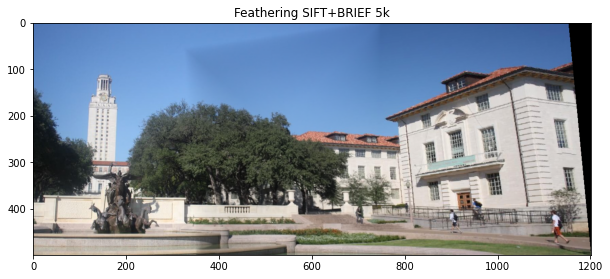

In [30]:
plt.figure(figsize=(10,10))
show(avg,"Average Blending")
plt.figure(figsize=(10,10))
show(base,"Prefer Base_Image Pixels")
plt.figure(figsize=(10,10))
show(other,"Prefer Other_Image Pixels")
plt.figure(figsize=(10,10))
show(special,"Feathering SIFT+SIFT 5k")
plt.figure(figsize=(10,10))
show(special,"Feathering SIFT+BRIEF 5k")

**Breve Discussão:**  
Aqui temos uma comparação de métodos básicos de blending com métodos mais elaborados. Além disso, como são imagens com iluminação diferente e um pouco de vignetting, é possível notar que nem mesmo o feathering foi capaz de uni-las de forma homogênea. Por vezes, alguns artefatos são gerados com o uso de feathering, normalmente são resolvidos se usarmos mais keypoints, o que acaba gerando mais casamentos e uma transformação melhor.

### Exemplo 2 - set1

O segundo exemplo é o primeiro conjunto de imagens fornecido.

In [31]:
src1 = 'img1-set1.jpg'
src2 = 'img2-set1.jpg'
src3 = 'img3-set1.jpg'

img1 = cv.imread(src1)
img2 = cv.imread(src2)
img3 = cv.imread(src3)

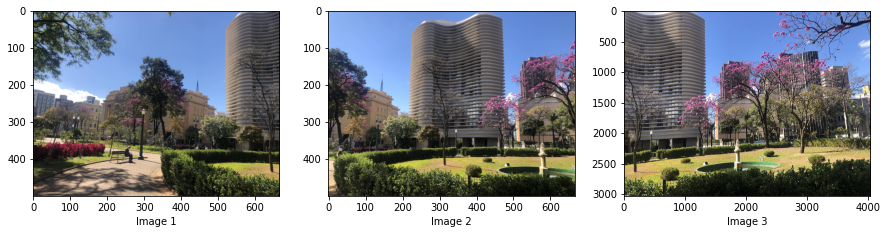

In [32]:
show3(img1, img2, img3, 500)

In [33]:
avg = panoramaMosaic3(img1, img2, img3, maxHeight=500,
                      blending_method='average', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 1000
FeaturesB: 1000
Raw matches (Brute force): 353
Matches
DrawMatches
Homography
Mosaic
img1->2 done
Grayscale
Keypoints
FeaturesA: 1001
FeaturesB: 1000
Raw matches (Brute force): 427
Matches
DrawMatches
Homography
Mosaic
img3->2 done
Mosaic


In [34]:
base = panoramaMosaic3(img1, img2, img3, maxHeight=500,
                       blending_method='base', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 1000
FeaturesB: 1000
Raw matches (Brute force): 353
Matches
DrawMatches
Homography
Mosaic
img1->2 done
Grayscale
Keypoints
FeaturesA: 1001
FeaturesB: 1000
Raw matches (Brute force): 427
Matches
DrawMatches
Homography
Mosaic
img3->2 done
Mosaic


In [35]:
special = panoramaMosaic3Special(img1, img2, img3, maxHeight=500, 
                                 n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 1000
FeaturesB: 1000
Raw matches (Brute force): 353
FeaturesA: 1001
FeaturesB: 1000
Raw matches (Brute force): 457
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [36]:
special2k = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                   n_kpts=2000, prints=False)

Grayscale
Keypoints
FeaturesA: 2000
FeaturesB: 2000
Raw matches (Brute force): 720
FeaturesA: 2000
FeaturesB: 2000
Raw matches (Brute force): 908
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [37]:
special3k = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                   n_kpts=3000, prints=False)

Grayscale
Keypoints
FeaturesA: 3000
FeaturesB: 3000
Raw matches (Brute force): 1113
FeaturesA: 3001
FeaturesB: 3000
Raw matches (Brute force): 1302
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [38]:
brief = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                               kpts_method='brief', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 817
FeaturesB: 975
Raw matches (Brute force): 236
FeaturesA: 921
FeaturesB: 975
Raw matches (Brute force): 297
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [39]:
brief2k = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                 kpts_method='brief', n_kpts=2000, prints=False)

Grayscale
Keypoints
FeaturesA: 1647
FeaturesB: 1946
Raw matches (Brute force): 482
FeaturesA: 1823
FeaturesB: 1946
Raw matches (Brute force): 580
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [40]:
brief3k = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                 kpts_method='brief', n_kpts=3000, prints=False)

Grayscale
Keypoints
FeaturesA: 2467
FeaturesB: 2915
Raw matches (Brute force): 728
FeaturesA: 2694
FeaturesB: 2915
Raw matches (Brute force): 802
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


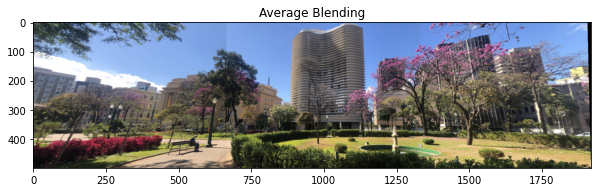

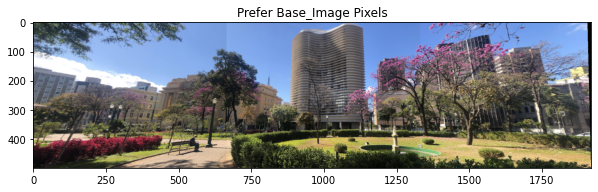

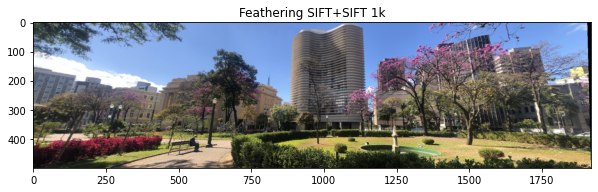

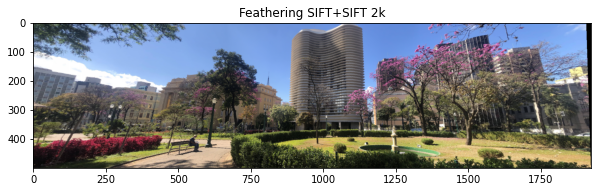

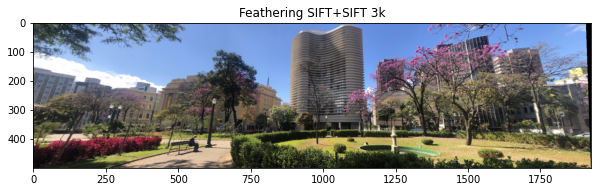

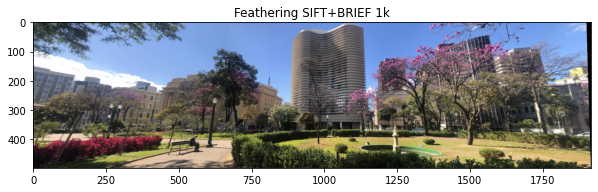

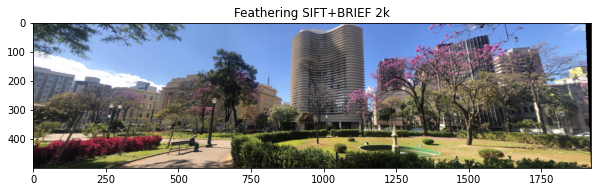

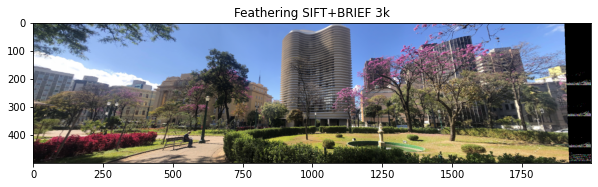

In [41]:
plt.figure(figsize=(10,10))
show(avg,"Average Blending")
plt.figure(figsize=(10,10))
show(base,"Prefer Base_Image Pixels")
plt.figure(figsize=(10,10))
show(special,"Feathering SIFT+SIFT 1k")
plt.figure(figsize=(10,10))
show(special2k,"Feathering SIFT+SIFT 2k")
plt.figure(figsize=(10,10))
show(special3k,"Feathering SIFT+SIFT 3k")
plt.figure(figsize=(10,10))
show(brief,"Feathering SIFT+BRIEF 1k")
plt.figure(figsize=(10,10))
show(brief2k,"Feathering SIFT+BRIEF 2k")
plt.figure(figsize=(10,10))
show(brief3k,"Feathering SIFT+BRIEF 3k")

**Breve Discussão**:  \
Essas imagens têm uma iluminação parecida, logo o blending da média deixa artefatos menos aparentes, mas ainda evidentes após uma simples observação. É interessante notar que com o feathering, foram necessários mais keypoints do que apenas os 1000 iniciais fornecidos para evitar artefatos. Ademais, o descritor SIFT precisou de mais de 2000 keypoints para não ter mais essas imperfeições, enquanto para o BRIEF foi suficiente até 2000. Quanto mais keypoints são reportados, mais potenciais casamentos e melhores transformações são feitas.

### Exemplo 3 - set2

O terceiro é o segundo conjunto de imagens fornecido.

In [42]:
src1 = 'img1-set2.jpg'
src2 = 'img2-set2.jpg'
src3 = 'img3-set2.jpg'

img1 = cv.imread(src1)
img2 = cv.imread(src2)
img3 = cv.imread(src3)

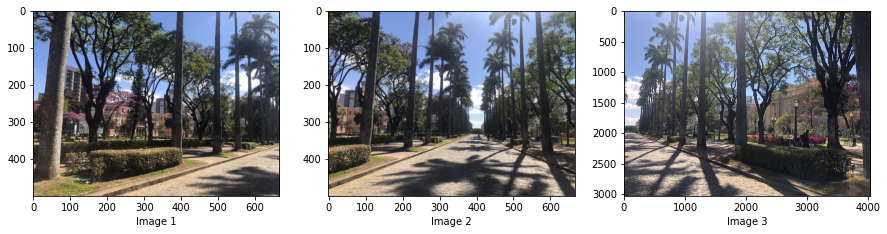

In [43]:
show3(img1, img2, img3, 500)

In [44]:
avg = panoramaMosaic3(img1, img2, img3, maxHeight=500,
                      blending_method='average', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 1000
FeaturesB: 1000
Raw matches (Brute force): 416
Matches
DrawMatches
Homography
Mosaic
img1->2 done
Grayscale
Keypoints
FeaturesA: 1000
FeaturesB: 1000
Raw matches (Brute force): 358
Matches
DrawMatches
Homography
Mosaic
img3->2 done
Mosaic


In [45]:
special = panoramaMosaic3Special(img1, img2, img3, maxHeight=500, 
                                 n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 1000
FeaturesB: 1000
Raw matches (Brute force): 416
FeaturesA: 1000
FeaturesB: 1000
Raw matches (Brute force): 356
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [46]:
brief = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                               kpts_method='brief', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 924
FeaturesB: 978
Raw matches (Brute force): 272
FeaturesA: 928
FeaturesB: 978
Raw matches (Brute force): 271
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


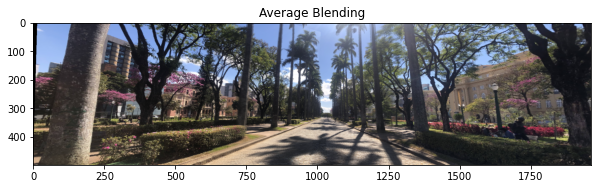

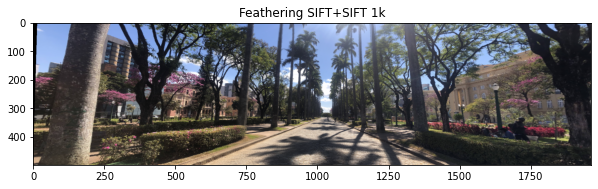

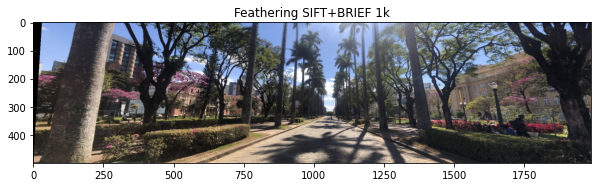

In [47]:
plt.figure(figsize=(10,10))
show(avg,"Average Blending")
plt.figure(figsize=(10,10))
show(special,"Feathering SIFT+SIFT 1k")
plt.figure(figsize=(10,10))
show(brief,"Feathering SIFT+BRIEF 1k")

**Breve Discussão**:  \
Nesse exemplo, o blending com o average tem poucos artefatos. Somente após uma cautelosa inspeção, nota-se, por exemplo, uma "borda" de iluminação, bem no meio da imagem, no topo, perto da árvore mais acima. Outro detalhe é que os descritores não precisaram de tantos keypoints para não apresentar imperfeições.

### Exemplo 4 - Parede de Instrumentos

O conjunto de imagens seguinte é de uma parede de casa que possui vários instrumentos.

In [48]:
src1 = 'mus1.jpg'
src2 = 'mus2.jpg'
src3 = 'mus3.jpg'

img1 = cv.imread(src1)
img2 = cv.imread(src2)
img3 = cv.imread(src3)

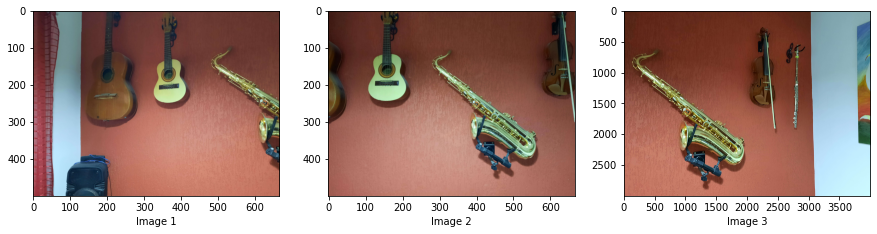

In [49]:
show3(img1, img2, img3, 500)

In [50]:
avg = panoramaMosaic3(img1, img2, img3, maxHeight=500,
                      blending_method='average', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 578
FeaturesB: 633
Raw matches (Brute force): 228
Matches
DrawMatches
Homography
Mosaic
img1->2 done
Grayscale
Keypoints
FeaturesA: 607
FeaturesB: 948
Raw matches (Brute force): 360
Matches
DrawMatches
Homography
Mosaic
img3->2 done
Mosaic


In [51]:
special = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                 n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 578
FeaturesB: 633
Raw matches (Brute force): 228
FeaturesA: 607
FeaturesB: 633
Raw matches (Brute force): 337
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [52]:
special2k = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                   n_kpts=2000, prints=False)

Grayscale
Keypoints
FeaturesA: 578
FeaturesB: 633
Raw matches (Brute force): 228
FeaturesA: 607
FeaturesB: 633
Raw matches (Brute force): 337
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [53]:
brief = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                               kpts_method='brief', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 441
FeaturesB: 605
Raw matches (Brute force): 137
FeaturesA: 596
FeaturesB: 605
Raw matches (Brute force): 270
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [54]:
brief2k = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                 kpts_method='brief', n_kpts=2000, prints=False)

Grayscale
Keypoints
FeaturesA: 441
FeaturesB: 605
Raw matches (Brute force): 137
FeaturesA: 596
FeaturesB: 605
Raw matches (Brute force): 270
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


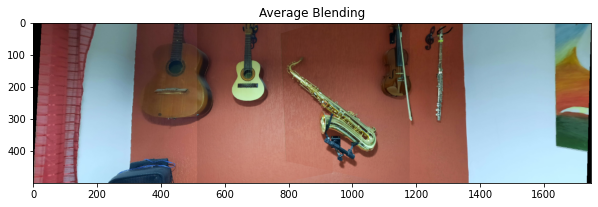

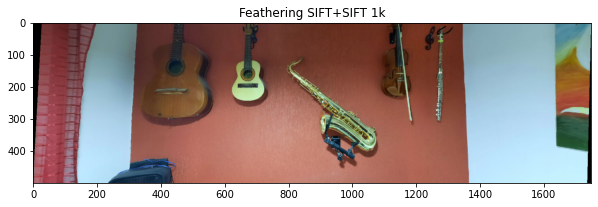

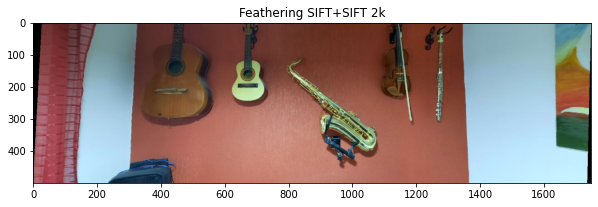

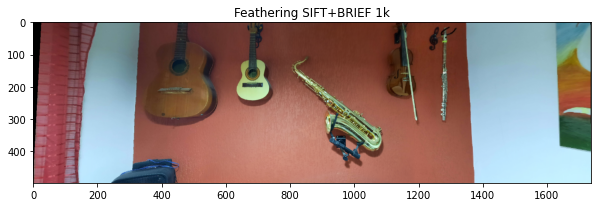

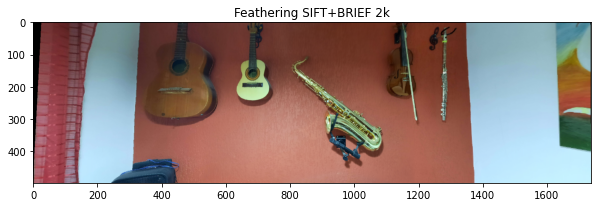

In [55]:
plt.figure(figsize=(10,10))
show(avg,"Average Blending")
plt.figure(figsize=(10,10))
show(special,"Feathering SIFT+SIFT 1k")
plt.figure(figsize=(10,10))
show(special2k,"Feathering SIFT+SIFT 2k")
plt.figure(figsize=(10,10))
show(brief,"Feathering SIFT+BRIEF 1k")
plt.figure(figsize=(10,10))
show(brief2k,"Feathering SIFT+BRIEF 2k")

**Breve Discussão:**  
Com esse conjunto de imagens, é possível notar que fazer blending com a média seria bem ruim nesse caso, há várias regiões com iluminação diferente. Além disso, diferentemente do set1 fornecido, vemos que não foram necessários mais de 2000 keypoints para evitar artefatos com o feathering. Esse exemplo é interessante pois mostra que o método funciona bem mesmo para alvos em planos não tão distantes da câmera. Todavia, a distorção perspectiva das transformações é consideravelmente maior e mais perceptível.

### Exemplo 5 - Paisagem

Também um conjunto obtido aqui de casa. Aqui temos a visão das casas e do bairro à frente.

In [56]:
src1 = 'sce1.jpg'
src2 = 'sce2.jpg'
src3 = 'sce3.jpg'

img1 = cv.imread(src1)
img2 = cv.imread(src2)
img3 = cv.imread(src3)

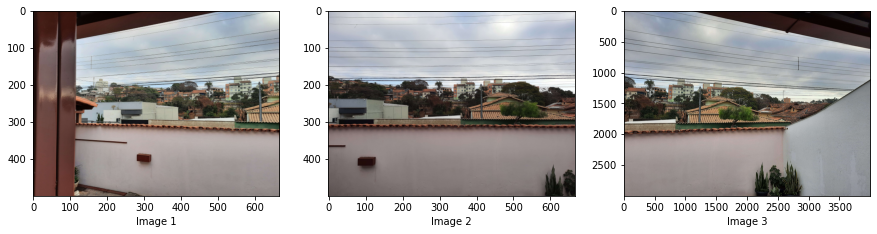

In [57]:
show3(img1, img2, img3, 500)

In [58]:
avg = panoramaMosaic3(img1, img2, img3, maxHeight=500,
                      blending_method='average', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 1000
FeaturesB: 911
Raw matches (Brute force): 387
Matches
DrawMatches
Homography
Mosaic
img1->2 done
Grayscale
Keypoints
FeaturesA: 886
FeaturesB: 1000
Raw matches (Brute force): 370
Matches
DrawMatches
Homography
Mosaic
img3->2 done
Mosaic


In [59]:
special = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                 n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 1000
FeaturesB: 911
Raw matches (Brute force): 387
FeaturesA: 886
FeaturesB: 911
Raw matches (Brute force): 401
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [60]:
special2k = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                   n_kpts=2000, prints=False)

Grayscale
Keypoints
FeaturesA: 1007
FeaturesB: 911
Raw matches (Brute force): 387
FeaturesA: 886
FeaturesB: 911
Raw matches (Brute force): 401
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [61]:
brief = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                               kpts_method='brief', n_kpts=1000, prints=False)

Grayscale
Keypoints
FeaturesA: 908
FeaturesB: 905
Raw matches (Brute force): 288
FeaturesA: 818
FeaturesB: 905
Raw matches (Brute force): 297
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [62]:
brief2k = panoramaMosaic3Special(img1, img2, img3, maxHeight=500,
                                 kpts_method='brief', n_kpts=2000, prints=False)

Grayscale
Keypoints
FeaturesA: 914
FeaturesB: 905
Raw matches (Brute force): 289
FeaturesA: 818
FeaturesB: 905
Raw matches (Brute force): 297
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


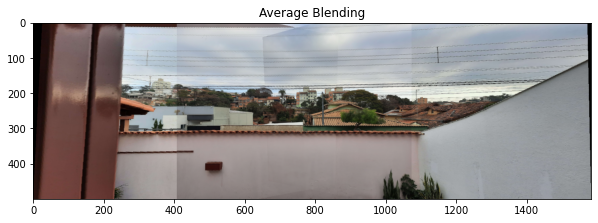

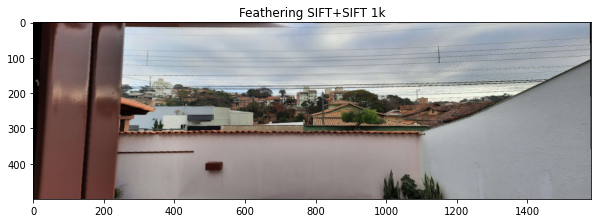

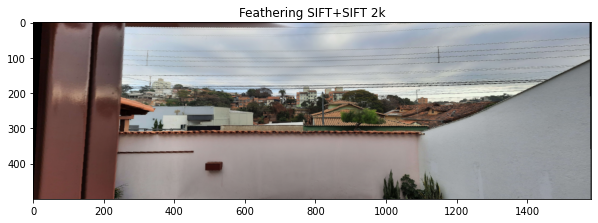

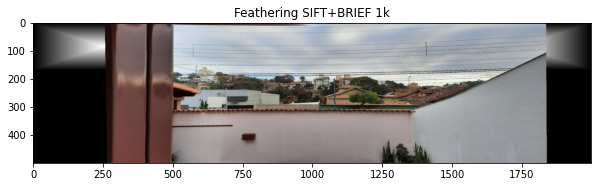

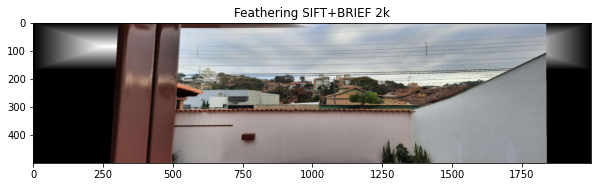

In [63]:
plt.figure(figsize=(10,10))
show(avg,"Average Blending")
plt.figure(figsize=(10,10))
show(special,"Feathering SIFT+SIFT 1k")
plt.figure(figsize=(10,10))
show(special2k,"Feathering SIFT+SIFT 2k")
plt.figure(figsize=(10,10))
show(brief,"Feathering SIFT+BRIEF 1k")
plt.figure(figsize=(10,10))
show(brief2k,"Feathering SIFT+BRIEF 2k")

**Breve Discussão:**  
Nesse panorama vemos mais uma vez vemos qual difícil é para o blending da média imagens com diferentes parâmetros de iluminação. Nem mesmo o feathering conseguiu propiciar uma cor homogênea ao muro rosa-claro, que acabou sendo representado com três tons diferentes. Mais uma vez, o feathering precisou de mais keypoints, sob pena de gerar artefatos fora do mosaico, em algumas execuções

### Exemplo 6 - Ilusão do Espelho

Por fim, temos um conjunto de imagens para criar um mosaico com espelhos, no qual nos valeremos do método para aparecermos em poses diferentes na mesma imagem conjunta.

In [64]:
src1 = 'mir1.jpg'
src2 = 'mir2.jpg'
src3 = 'mir3.jpg'

img1 = cv.imread(src1)
img2 = cv.imread(src2)
img3 = cv.imread(src3)

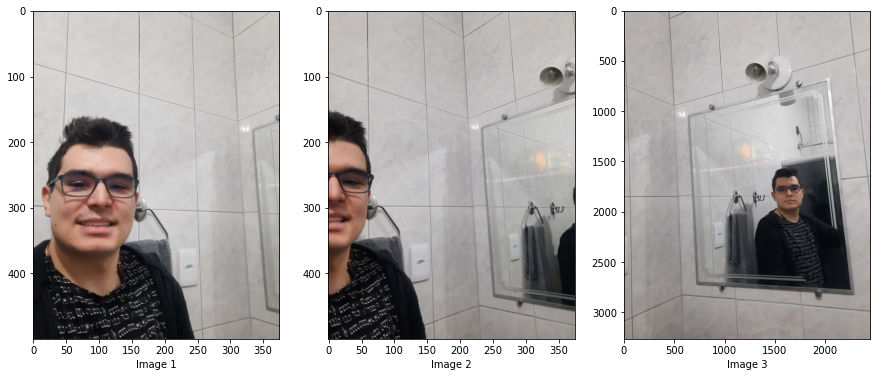

In [65]:
show3(img1, img2, img3, maxHeight=500)

In [66]:
avg = panoramaMosaic3(img1, img2, img3, maxHeight=750,
                      blending_method='average', n_kpts=3000, prints=False)

Grayscale
Keypoints
FeaturesA: 836
FeaturesB: 761
Raw matches (Brute force): 365
Matches
DrawMatches
Homography
Mosaic
img1->2 done
Grayscale
Keypoints
FeaturesA: 489
FeaturesB: 1145
Raw matches (Brute force): 216
Matches
DrawMatches
Homography
Mosaic
img3->2 done
Mosaic


In [67]:
special = panoramaMosaic3Special(img1, img2, img3, maxHeight=750, n_kpts=3000, prints=False)

Grayscale
Keypoints
FeaturesA: 836
FeaturesB: 761
Raw matches (Brute force): 365
FeaturesA: 489
FeaturesB: 761
Raw matches (Brute force): 200
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


In [68]:
brief = panoramaMosaic3Special(img1, img2, img3, maxHeight=750,
                               kpts_method='brief', n_kpts=3000, prints=False)

Grayscale
Keypoints
FeaturesA: 724
FeaturesB: 703
Raw matches (Brute force): 249
FeaturesA: 457
FeaturesB: 703
Raw matches (Brute force): 146
Matches
DrawMatches
Homography
Transform img1
Transform img3
Masks 12
Masks 32
Mosaic


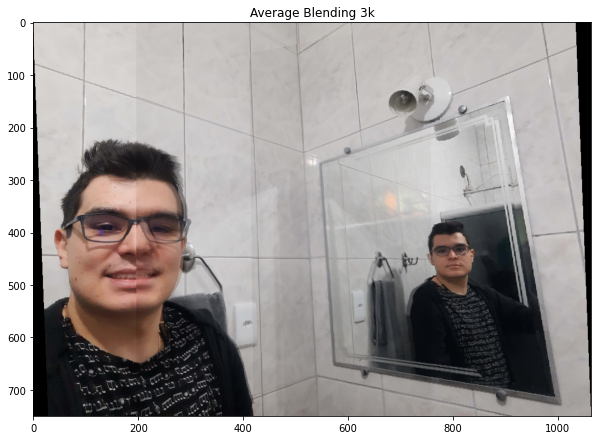

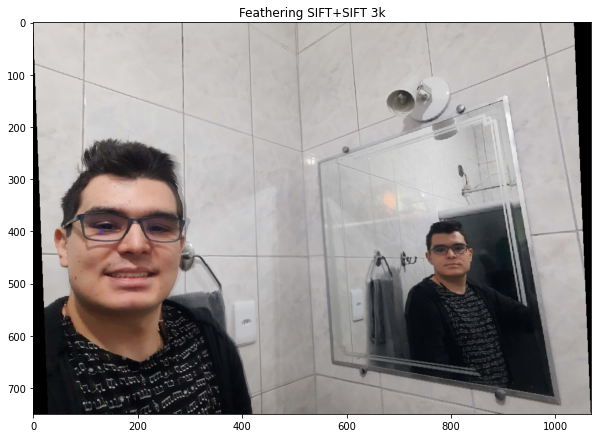

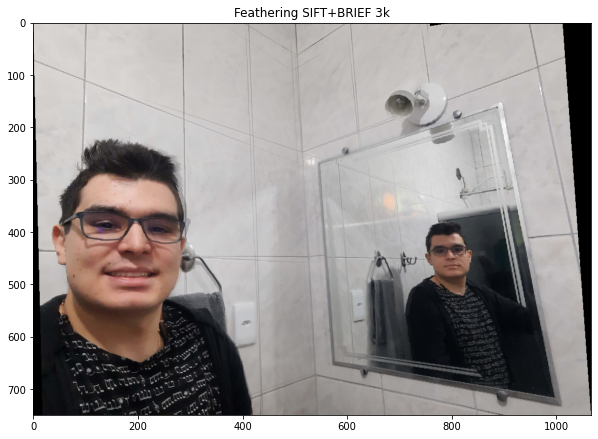

In [69]:
plt.figure(figsize=(10,10))
show(avg,"Average Blending 3k")
plt.figure(figsize=(10,10))
show(special,"Feathering SIFT+SIFT 3k")
# plt.figure(figsize=(10,10))
# show(special2k,"Feathering SIFT+SIFT 2k")
plt.figure(figsize=(10,10))
show(brief,"Feathering SIFT+BRIEF 3k")
# plt.figure(figsize=(10,10))
# show(brief2k,"Feathering SIFT+BRIEF 2k")

**Breve Discussão:**  
Essa montagem famosa na Internet gera um pouco de ghosting mais pela coleta da imagem do que pelo método em si. É bem complicado de tirar uma foto apenas rotacionando a câmera frontal do celular se você também aparece. Apesar desses artefatos, ainda é um interessante aplicação do mosaico panorama. Além disso, como a imagem é de perto, há bastante deformação das imagens para que elas se encaixem, denotado por serrilhamentos em várias linhas retas (como a borda do espelho).

## Discussões Finais
É possível tecer algumas conclusões a partir dos métodos implementados, qualitativamente. A primeira é que se as imagens não tiverem grandes diferenças de iluminação ou um efeito vignetting muito destacado a média apresenta resultados razoáveis. Quanto mais discrepantes forem as imagens do mosaico, mais evidentes serão os artefatos do blending entre elas.

Ainda nesse aspecto, a técnica do feathering apresenta resultados superiores. Contudo, ainda assim, ele não é perfeito, se as imagens tiverem diferença muito grande, fica clara a região de interseção. Quando elas são parecidas, é praticamente imperceptível notar essa região. Além disso, por vezes o feathering gera artefatos fora da área do mosaico.

Sobre o feathering, também, é possível notar que, em termos de implementação, dado o uso de máscaras e necessidades das fotos antes de algum processamento, esse método não permite tanta modularização. Como fins de comparação, pode-se ver que a função que cria os panoramas com blending simples a partir de 3 imagens faz duas chamadas para a que cria a partir de 2. Esse refactor não foi tão evidente a ponto de ser feito com o processo de feathering.

É importante também ressaltar a questão de performance dos algoritmos implementados. Usa-se aqui o Brute-Force matcher, que por si só já não ajuda muito o desempenho, combinado com funções _warpPerspective_ implementadas sem muita otimização, apenas com loops aninhados que iteram por toda a imagem. Assim, imagens grandes demorarão consideravelmente mais. Por isso, as funções que criam o panorama, antes de tudo, fazem um resize das imagens de entrada exatamente para tentar melhorar o tempo de execução. Uma possibilidade para dirimir um pouco esse efeito seria usar um outro casador de keypoints como o kNN, citado nas referências consultadas, mas não utilizado aqui.

Sob esse mesmo âmbito, convém um alerta sobre tempo de execução. O notebook demora algum tempo para executar por completo, da ordem de minutos. Logo deve-se ter essa informação em mente antes de limpar todos os outputs.

Um último aspecto a ser discutido é que fica evidente que o método se comportou bem tanto em situações com cenas mais distantes quanto com cenas mais próximas da câmera, apesar de que nestas últimas, há uma maior distorção.

Por fim, em suma, nota-se que a criação de mosaicos panorama foi muito bem sucedida. Foi possível aplicar os conceitos aprendidos em sala sobre keypoints, descritores e homografia enquanto se implementa uma ferramenta que está disponível a nós todos em nossos celulares. Ao meu ver a atividade foi, de fato, muito produtiva.

## Referências

Nascimento, Erickson R. **Homography, Robust Fitting, and Mosaicing**. UFMG: 2021

Silva, Thalles. **Image Panorama Stitching with OpenCV**. Towards Data Science: 2019.   
Disponível em: https://towardsdatascience.com/image-panorama-stitching-with-opencv-2402bde6b46c . Acesso em: 13 jul. 2021  
Código completo disponível em: https://colab.research.google.com/drive/11Md7HWh2ZV6_g3iCYSUw76VNr4HzxcX5. Acesso em: 13 jul. 2021

OpenCV, **BRIEF (Binary Robust Independent Elementary Features)**.<br>
Disponível em: https://docs.opencv.org/4.5.2/dc/d7d/tutorial_py_brief.html. Acesso em: 13 jul. 2021

Nayar, Shree. **First Principles of Computer Vision**. 
First Principles of Computer Vision: 2021.   
Disponível em: https://www.youtube.com/watch?v=1EJ84QqkxWc . Acesso em: 23 jul. 2021 

Collins, Robert. **Lecture 17:Mosaicing and Stabilization**. Penn State University: 2007   
Disponível em: http://www.cse.psu.edu/~rtc12/CSE486/lecture17.pdf . Acesso em: 23 jul. 2021